# A notebook to develop the script, generate results and do some plots.
Testing is in the


In [40]:
#!/usr/bin/env python
'''
Created on 

@author: manuel.dominguezbecerra@nhs.net

'''


# Import libraries 
import seaborn as sns
import argparse                          # pip install argparse
import pandas as pd                      # pip install dash
import os
import subprocess
import numpy as np

import dash                              # pip install dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Output, Input

from dash_extensions import Lottie       # pip install dash-extensions
import dash_bootstrap_components as dbc  # pip install dash-bootstrap-components
import plotly.express as px              # pip install plotly
from datetime import date
import calendar
from wordcloud import WordCloud          # pip install wordcloud
import sqlite3                           # pip install sqlite3
import plotly.graph_objects as go
import dash_table
from dash.dependencies import Input, Output, State


# To allow the user to introduce the file after running "python run.ppy"

# Example:    python run.py -- /path/file_name1 -- /path/file_name2

   ### 1. Take the files
    
# During the development of this application, I have needed to run the script many times
# To do this in a easy way, I directly introduce here the path/file_name in a variable
# As it can be seen below

Name_file1 = "/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/2/W2013397_S6.vcf"

Name_file2 = "/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/20/W2010438_S4.vcf"

# In the script, the previous two lines doesn´t appear and the following lines are incommeneted

#parser = argparse.ArgumentParser()
#parser.add_argument('--vcf1', type=str, required=True)
#parser.add_argument('--vcf2', type=int, required=True)
#args = parser.parse_args()
#Name_file1 = args.vcf1 
#Name_file2 = args.vcf2

# This 6 lines allow the user to select the two neccesary files to run the script

#During the development, the few lines make running the script easier.
# In the run.py script, the previous lines are uncommented and the following lines are deleted.




# From here to the end the following lines are identical that the one find in the script


   ### 2. Take only the data contains in the vcf files.

# Originally what I did was to delete the metedata and save in a new file the data
# This approach was over complicated and doesn´t work in window machines.
# Instead of this, the new approach directly take the data and save it in pandas dataframe object.
# This is also a more efficient method.

# For the file number 1
with open(Name_file1, 'r') as f:
    for line in f:
        if line.startswith('#') and len(line)>2 and line[1] != '#':
            columns = line[1:-1].split('\t')
            break

dataA = pd.read_csv(Name_file1, comment='#', delimiter='\t', names=columns)

# For the second file
with open(Name_file2, 'r') as f:
    for line in f:
        if line.startswith('#') and len(line)>2 and line[1] != '#':
            columns = line[1:-1].split('\t')
            break
            
dataB = pd.read_csv(Name_file2, comment='#', delimiter='\t', names=columns)


# If the pd data frame has more than 10 columns
# that means there are more than 1 sample in the vcf file
# If more than one file is found, next lines ask which sample to take.

if len(dataA.columns) > 10:
     Name_sample1 = input('It seems that {} has more than one sample. Please introduce the name of the sample you wish to analyse:  '.format(os.path.basename(Name_file1)))
else:
    print('File', os.path.basename(Name_file1), 'contains one sample only.')
    Name_sample1 = dataA.columns.tolist()[9]

if len(dataB.columns) > 10:
     Name_sample2 = input('It seems that {} has more than one sample. Please introduce the name of the sample you wish to analyse:  '.format(os.path.basename(Name_file2)))
else:
    print('File', os.path.basename(Name_file2), 'contains one sample only.')
    Name_sample2 = dataB.columns.tolist()[9]

    ### 3. Filter the variants  
    
    
# Two filters are applied. First, I take only the variants that "PASS" the "FILTER" field. 
# This is a mandatory field.

# Then, I take only the variants which Variant Frecuency (VF) is highter or eqqual than. 0.4
# This is not a mandatory field in vcf filed

# VF is in the 9th column with another data. Example: GT:GQ:AD:VF:NL:SB:GQX   0/1:100:3501,254:0.0676:20:-100.0000:100
#we need to extract and put VF data in an independent column first
df2 = dataA[Name_sample1].str.split(':', expand=True)

df2 = df2.fillna(value=np.nan)
df2 = df2.dropna(axis=1, how='any')

df2.columns = dataA.FORMAT.iloc[0].split(':')
dataA = pd.concat([dataA, df2], axis=1)

# Same for dataB
df3 = dataB[Name_sample2].str.split(':', expand=True)
df3 = df3.fillna(value=np.nan) 
df3 = df3.dropna(axis=1, how='any') 

df3.columns = dataB.FORMAT.iloc[0].split(':')
dataB = pd.concat([dataB, df3], axis=1)

# Now, let´s filter the variant
# We dont want variants that doesnt pass the Filter status
# This field is mandatory, no condition is needed because it is applied to any type of VCF file.
dataA = dataA.query('FILTER == "PASS"')
dataB = dataB.query('FILTER == "PASS"')
                    
# Now, I apply Variant Frecuency (VF) filter (non-mandatory field)

# If there is a VF Genotype fields in the file
# Take the variants that are > 0.4
# If not, no VF filter is applied

if "VF" in dataA.columns:
    dataA["VF"] = dataA["VF"].astype(float)
    dataA = dataA.query('VF > 0.4')
    
if "VF" in dataB.columns:
    dataB["VF"] = dataB["VF"].astype(float)
    dataB = dataB.query('VF > 0.4')
    

   ### 4. Variants comparison

# Two variants are the same if  CHROM, POS, REF, ALT and GT are equal

dataA['CHROMPOSREDALT']= dataA["CHROM"].apply(str)+"."+dataA["POS"].apply(str)+dataA["REF"]+"."+dataA["ALT"]

dataB['CHROMPOSREDALT']= dataB["CHROM"].apply(str)+"."+dataB["POS"].apply(str)+dataB["REF"]+"."+dataB["ALT"]


df3 = dataA[['CHROMPOSREDALT', 'GT']].copy()
df4 = dataB[['CHROMPOSREDALT', 'GT']].copy()
frames = [df3,df4]
semi_final_df = pd.concat(frames)
# semi_final_df saves the CHROM, POS, REF, ALT in the first column and the GT in the second column


#Example:
'''
CHROMPOSREDALT     GT

chr1.123456T.C     0/1       From sample 1
chr2.123456A.C     1/1       From sample 1
chr1.123456T.C     0/1       From sample 2

'''


# Let´s reduce the number of rows
final_df=(semi_final_df.assign(key=semi_final_df.groupby('CHROMPOSREDALT').cumcount())
      .pivot('CHROMPOSREDALT','key','GT')
      .rename(columns=lambda x:f"Sample{x+1}")
      .rename_axis(columns=None).reset_index())

# Final_df contains all common and non-common variants that passed the filters

# The pivot command gives NaNs in the column of the second sample when a variant is only found in one of the samples
# This NaN values return errors in the following lines. This is an error I have found when the script was developed
# To solve the issue without introducing many changes, NaN values are replace for 99/99 values.
final_df = final_df.replace(np.NaN,"99/99" )

   ### 4. See how many GT match

# Variables needed for both type of reports

r0 = os.path.basename(Name_file1) # Get the  file name of a path/file_name 
r1 = Name_sample1                 # Get the name of the sample 1
r2 = os.path.basename(Name_file2)
r3 = Name_sample2

if "Sample2" not in final_df.columns:
    # If Sample2 is not in final_df, that means there is not common position between the samples.
    report0 = '''
 _____________________________  REPORT  ________________________________________ 

vcf 1: {0}  AND its sample name: {1}  
vcf 2:  {2}  AND its sample name: {3}

   No common positions found between samples

 ____________________________ END REPORT  _______________________________________
'''
    print(report0.format(r0,r1,r2,r3,))

else:    
    # else match common position and carry on the report.
    final_df["Matches"] = np.where(final_df["Sample1"] == final_df["Sample2"], True, False)
    final_df.columns = ['CHROM.POS.REF.ALT',os.path.basename(Name_file1),os.path.basename(Name_file2),"Matches" ]

    # 6.  To get hom and het 

    final_df['Genotype1'] = final_df.iloc[:,2].apply(lambda x: x.split('/' or '|')[0])
    final_df['Genotype2'] = final_df.iloc[:,2].apply(lambda x: x.split('/' or '|')[1])
    
    final_df['final_match'] = np.select([final_df['Matches'] & final_df['Genotype1'].eq(final_df['Genotype2']),
                       final_df['Matches'] & final_df['Genotype1'].ne(final_df['Genotype2'])],
                       choicelist=[True, False],
                       default=pd.NA)

   ### 6. Generate results in the terminal

# Variable to introduce in the report :
    
    r4 = final_df['Matches'].value_counts().get(True, 0) # Count trues if any, retunr 0
    r5 = final_df['final_match'].value_counts().get(True, 0)
    r6 =final_df['final_match'].value_counts().get(False, 0)
    r7 = final_df['Matches'].value_counts().get(False, 0)
    r8 = len(final_df)
    r9 = r4/(r4+r7)
    report = '''
 _____________________________  REPORT  ________________________________________ 

vcf 1: {0}  AND its sample name: {1}  
vcf 2:  {2}  AND its sample name: {3}

                                                  Homozigous: {5} 
Number of positions with the same genotype: {4} 
                                                  Heterozigous: {6} 
                                                
                                                  
Number of positions with different genotype: {7} 
                                                  


Total positions compared: {8}
Percentage in common: {4}/{8}= {9}

 ____________________________ END REPORT  _______________________________________
'''
    print(report.format(r0,r1,r2,r3,r4,r5,r6,r7,r8,r9))
    
# ========== Results ================== #

# To store results in lists and then in df

# To create the list the first iteration
#sampleA = ["hola"]
#sampleB = ["hola"]
#Total_positions_comp = ["hola"]
#Pos_same_genotype = ["hola"]
#Pos_different_genotyope = ["hola"]
#Hom = ["hola"]
#Het = ["hola"]

#sampleA.append(r1)
#sampleB.append(r3)
#Total_positions_comp.append(r8)
#Pos_same_genotype.append(r4)
#Pos_different_genotyope.append(r7)
#Hom.append(r5)
#Het.append(r6)    



# draft

#(semi_final_df.pivot_table(index = ['CHROMPOSREDALT'], aggfunc ='size')==2).value_counts()[1] # position same genotipe
#position_same_genotype = (semi_final_df.pivot_table(index = ['CHROMPOSREDALT'], aggfunc ='size')==2).value_counts()[1]
#total_hom = semi_final_df[semi_final_df.GT == '1/1'].shape[0]
#total_het = semi_final_df[semi_final_df.GT != '1/1'].shape[0]
#final_df = final_df.astype(str)

File W2013397_S6.vcf contains one sample only.
File W2010438_S4.vcf contains one sample only.

 _____________________________  REPORT  ________________________________________ 

vcf 1: W2013397_S6.vcf  AND its sample name: W2013397  
vcf 2:  W2010438_S4.vcf  AND its sample name: W2010438

                                                  Homozigous: 18 
Number of positions with the same genotype: 30 
                                                  Heterozigous: 12 
                                                
                                                  
Number of positions with different genotype: 55 
                                                  


Total positions compared: 85
Percentage in common: 30/85= 0.35294117647058826

 ____________________________ END REPORT  _______________________________________



In [79]:
semi_final_df

,CHROMPOSREDALT,GT
3,chr1.36933096T.C,0/1
9,chr2.25463483G.A,0/1
13,chr2.25466888G.T,1/1
16,chr2.25469502C.T,0/1
25,chr2.198267770G.GAA,0/1
...,...,...
274,chrX.123200313AT.A,0/1
275,chrX.123200482ATTG.A,0/1
279,chrX.129147079T.C,1/1
288,chrX.129190217C.T,0/1


In [41]:
# To see is lists are storing data correctly
print(sampleA)
print(sampleB)
print(Total_positions_comp)
print(Pos_same_genotype)
print(Pos_different_genotyope)
print(Hom)
print(Het)

['hola', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W1815770', 'W2013397', 'W2013397', 'W2013397', 'W2013397', 'W2013397', 'W2013397', 'W2013397', 'W2013397', 'W2013397', 'W2013397', 'W2013397', 'W2013397', 'W2013397', 'W2013397', 'W2013397', 'W2013397']
['hola', 'W2013397', 'W2008872', 'W1906436', 'W1922549', 'W2017353', 'W2017475', 'W2013237', 'W2102164', 'W2000136', 'W2002769', 'W2102033', 'W1922376', 'W2101694', 'W2101517', 'W2101417', 'W2101157', 'W2101130', 'W2101083', 'W2101032', 'W2100941', 'W2008872', 'W1906436', 'W2102707', 'W2102609', 'W2102400', 'W2102210', 'W2102164', 'W2102033', 'W2101810', 'W2101694', 'W2101517', 'W2101417', 'W2101130', 'W2101083', 'W2101032', 'W2010438']
['hola', 77, 85, 85, 80, 80, 86, 70, 76, 72, 72, 71, 80, 82, 77, 78, 89, 76, 77, 79, 91, 78, 79, 79, 73, 78, 63, 72, 6

In [42]:
# Save lists in a df
results = pd.DataFrame(list(zip(sampleA, sampleB,Total_positions_comp,Pos_same_genotype,Pos_different_genotyope,Hom,Het)),
               columns=['Sample_A','Sample_B','Total_positions_comp','Pos_same_genotype','Pos_different_genotyope','Hom','Het'])
results = results[1:]


In [43]:
# To get proportion of sites with common genotype
results["identical_position (%)"] = results["Pos_same_genotype"]/results["Total_positions_comp"]

In [71]:
# To save 
total_results = pd.read_csv("/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/Results/both_patients.csv")
total_results

,Sample_A,Sample_B,Total_positions_comp,Pos_same_genotype,Pos_different_genotyope,Hom,Het,identical_position (%),Samples:
0,W1815770,W2103070,63,59,4,20,39,0.936508,Matched
1,W2013397,W2103016,60,55,5,30,25,0.916667,Matched
2,W2008872,W2103014,59,56,3,23,33,0.949153,Matched
3,W1906436,W2010731,63,58,5,38,20,0.920635,Matched
4,W1906436,W2100789,82,29,53,20,9,0.353659,Matched
...,...,...,...,...,...,...,...,...,...
57,W2013397,W2101417,73,31,42,18,13,0.424658,Unmatched
58,W2013397,W2101130,74,29,45,17,12,0.391892,Unmatched
59,W2013397,W2101083,72,30,42,16,14,0.416667,Unmatched
60,W2013397,W2101032,75,30,45,18,12,0.400000,Unmatched


[Text(0.5, 0, 'Proportion of sites with common genotypes'),
 Text(0, 0.5, 'Number of positions compared')]

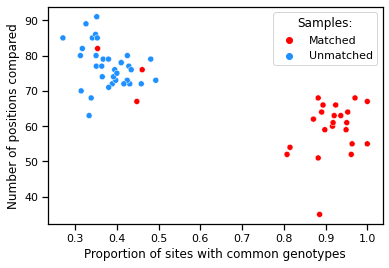

In [73]:
# To generater the plot
sns.set_context('notebook')
sns.scatterplot(data=total_results, x="identical_position (%)", y="Total_positions_comp",
               hue = "Samples:",
               palette=['red',"dodgerblue"], legend='full',
               ).set(xlabel="Proportion of positions with common genotypes",
                    ylabel="Number of positions compared")

In [ ]:
Total_positions_comp

In [ ]:
Pos_same_genotype

In [ ]:
Pos_different_genotyope

In [ ]:
final_df

In [ ]:
final_df.replace(np.NaN,"99/99" )

In [ ]:
final_df

In [ ]:
Name_file1 = "/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/1/W1815770_S16.vcf"
Name_file2 = "/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/1/W2103070_S8.vcf"



# Files to pandas object
with open(Name_file1, 'r') as f:
    for line in f:
        if line.startswith('#') and len(line)>2 and line[1] != '#':
            columns = line[1:-1].split('\t')
            break
df = pd.read_csv(Name_file1, comment='#', delimiter='\t', names=columns)
df
#import re
### 1. Remove the header of input files

#print (re.sub(r'^##.*\n?', '', Name_file1, flags=re.MULTILINE))

# File A
#cmd = "sed '/^##/ d'  {0} >  FileA.txt".format(Name_file1)
#os.system(cmd)

# File B 
#cmd = "sed '/^##/ d'  {0} >  FileB.txt".format(Name_file2)
#os.system(cmd)

# Files to pandas object
#dataA = pd.read_csv("./FileA.txt", delimiter = "\t" )
#dataB = pd.read_csv("./FileB.txt", delimiter = "\t" )

In [ ]:

# NOOOOOOOO BORRARRRR ######################################


### 6. Generate a report in a dashboard
# Bootstrap themes by Ann: https://hellodash.pythonanywhere.com/theme_explorer
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.SIMPLEX])

app.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            dbc.Card([
                dbc.CardImg(src='./assets/wrgllogohighres.jpeg')
                ],color="light", outline=True),
                ],width=3),
                dbc.Col([
                    dbc.Card([
                        dbc.CardImg(src='./assets/salisbury-nhs-foundation-trustLeft.png')
                             ],color="light", outline=True)
                        ],width=2)
            ],justify="between"),
        dbc.Row(
            [dbc.Card([ 
                dbc.CardBody([
                    html.Div([
                    html.H1("Report: Do the samples belong to the same patient?"),
                    html.H3("This application takes common variants and compares the GT fields. A relative large number of common variants which GT fields match is indicative that both samples have a close relationship."),
                ], style={'textAlign': 'center'}) 
                     ], style={'textLeft':'center', })      
                      ], style={'height':'10vh'},color="light", outline=True),
        ]),
        dbc.Row([
            dbc.Card([ 
                dbc.CardBody([
                    html.Div([
                    html.H1(""),
                    html.H3(""),
                ], style={'textAlign': 'center'}) 
                     ], style={'textLeft':'center', })      
                      ], style={'height':'10vh'},color="light", outline=True),
        ]),
        dbc.Row([  
            dbc.Col([
            dash_table.DataTable(
        id='datatable-interactivity',
        columns=[
            {"name": i, "id": i, "deletable": True, "selectable": True, "hideable": True}
            if i == "iso_alpha3" or i == "year" or i == "id"
            else {"name": i, "id": i, "deletable": True, "selectable": True}
            for i in final_df.columns
        ],
        data=final_df.to_dict('records'),  # the contents of the table html.H3(os.path.basename(Name_file1)),
        filter_action="native",     # allow filtering of data by user ('native') or not ('none')
        sort_action="native",       # enables data to be sorted per-column by user or not ('none')
        sort_mode="single",         # sort across 'multi' or 'single' columns
        row_deletable=True,         # choose if user can delete a row (True) or not (False)
        selected_rows=[],           # indices of rows that user selects
        page_action="native",       # all data is passed to the table up-front or not ('none')
        page_current=0,             # page number that user is on
        style_cell={                # ensure adequate header width when text is shorter than cell's text
            'minWidth': 200, 'maxWidth': 95, 'width': 95
        },
        style_data_conditional=[
        {
            'if': {'row_index': 'odd'},
            'backgroundColor': 'rgb(248, 248, 248)'
        }
    ],
        style_header={
        'backgroundColor': 'rgb(230, 230, 230)',
        'fontWeight': 'bold'
    })]),
    dbc.Col([
        dbc.Card([ 
            dbc.CardBody([
                html.Div([
                    html.H4("Number of common variants:",style={'color': 'black', 'fontSize': 15}),
                    html.H4(len(final_df)),
                    html.H4("Number of matches:", style={'color': 'black', 'fontSize': 15}),
                    html.H4(final_df.Matches.value_counts()[1]),
                    ], 
                    style={'textAlign': 'left'})
                    ])
                    ],
                    style={'height':'8vh'},color="light", outline=True),
                    ])
                    ])
                    ])



  


if __name__ == '__main__':
    app.run_server(debug=False)




In [ ]:

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/1/W1815770_S16.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/1/W2103070_S8.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/2/W2013397_S6.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/2/W2103016_S15.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/3/W2008872_S8.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/3/W2103014_S10.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/4/W1906436_S11.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/4/W2010731_S10.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/4/W2100789_S9.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/5/W2012950_S3.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/5/W2012950_S10.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/5/W2102707_S6.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/6/W1922549_S1.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/6/W2102681_S3.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/7/W2017353_S16.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/7/W2102609_S15.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/8/W2017475_S3.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/8/W2102400_S16.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/9/W2013237_S11.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/9/W2102210_S7.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/10/W2014615_S12.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/10/W2102164_S5.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/11/W2000136_S7.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/11/W2002769_S14.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/11/W2102033_S6.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/12/W1922376_S2.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/12/W2101810_S7.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/13/W1902904_S9.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/13/W2101694_S12.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/14/W1814542_S10.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/14/W2101517_S1.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/15/W2002517_S15.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/15/W2006956_S14.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/15/W2101417_S2.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/16/W1906283-003_S1.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/16/W2101157_S8.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/17/W2009066_S16.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/17/W2101130_S5.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/18/W1806167_S4.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/18/W2101083_S9.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/19/W2009316_S2.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/19/W2012284_S12.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/19/W2101032_S15.vcf

#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/20/W2010438_S4.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/20/W2013228_S11.vcf
#/Users/monkiky/Desktop/VCF-matcher/Samples/Same_patients/20/W2100941_S16.vcf
#

